In [2]:
!python -m venv tfenv

c:\Python27\python.exe: No module named venv


In [3]:
!pip install -q tensorflow

In [7]:
%pip install -q scipy opencv-python scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install -q tensorflow tensorflow-addons tensorflow-hub tensorflow-datasets
!pip install  gdown matplotlib seaborn 
!pip install keras-facenet



  Using cached tensorflow-2.20.0-cp312-cp312-win_amd64.whl.metadata (4.6 kB)


ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached matplotlib-3.10.5-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.1-cp312-cp312-win_amd64.whl.metadata (111 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached numpy-2.3.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached pillow-11.3.0-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pandas-2.3.1-cp31

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics, Model
# import tensorflow_hub as hub
from keras_facenet import FaceNet # type: ignore
import pandas as pd
import numpy as np
import os
from pathlib import Path
import zipfile
import gdown
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import drive, files
import warnings
warnings.filterwarnings('ignore')

In [12]:
# drive.mount('/content/drive')
DATASET_PATH = "C:/Users/aa24afl/Downloads/FairFace"
# DATASET_PATH = "C:/Users/DELL/Downloads/datasets/FairFace"

In [13]:

if os.path.exists(DATASET_PATH):
    print("Path exists.")
else:
    print("Path does not exist.")

# Verify dataset structure
expected_files = [
    "train_labels.csv",
    "val_labels.csv",
    "train/",
    "val/"
]

print(f"Loading dataset from: {DATASET_PATH}")

# Check if all required files/folders exist
missing_files = []
for item in expected_files:
    if not os.path.exists(os.path.join(DATASET_PATH, item)):
        missing_files.append(item)

if missing_files:
    raise FileNotFoundError(
        f"Dataset incomplete. Missing: {missing_files}\n"
        f"Expected structure:\n"
        f"{DATASET_PATH}/\n"
        f"├── train_labels.csv\n"
        f"├── val_labels.csv\n"
        f"├── train/ [contains images]\n"
        f"└── val/   [contains images]"
    )


# Set paths for data loading
TRAIN_CSV_PATH = os.path.join(DATASET_PATH, "train_labels.csv")
VAL_CSV_PATH = os.path.join(DATASET_PATH, "val_labels.csv")
TRAIN_IMG_DIR = os.path.join(DATASET_PATH, "train")
VAL_IMG_DIR = os.path.join(DATASET_PATH, "val")

print("\nDataset structure verified:")
print(f"Training CSV:   {TRAIN_CSV_PATH}")
print(f"Validation CSV: {VAL_CSV_PATH}")
print(f"Training images: {TRAIN_IMG_DIR} ({len(os.listdir(TRAIN_IMG_DIR))} files)")
print(f"Validation images: {VAL_IMG_DIR} ({len(os.listdir(VAL_IMG_DIR))} files)")

Path exists.
Loading dataset from: C:/Users/aa24afl/Downloads/FairFace

Dataset structure verified:
Training CSV:   C:/Users/aa24afl/Downloads/FairFace\train_labels.csv
Validation CSV: C:/Users/aa24afl/Downloads/FairFace\val_labels.csv
Training images: C:/Users/aa24afl/Downloads/FairFace\train (86744 files)
Validation images: C:/Users/aa24afl/Downloads/FairFace\val (10954 files)


In [14]:
class FairFaceDataProcessor:
    def __init__(self, csv_path, img_dir, img_size=160, sample_size=None, is_validation=False):
        self.img_size = img_size
        self.img_dir = img_dir
        self.is_validation = is_validation

        # Load CSV data
        self.df = pd.read_csv(csv_path)

        # Filter dataset to keep only valid age groups
        valid_age_groups = [
            '0-2', '3-9', '10-19', '20-29', '30-39',
            '40-49', '50-59', '60-69', 'more than 70'
        ]
        original_len = len(self.df)
        self.df = self.df[self.df['age'].isin(valid_age_groups)].reset_index(drop=True)
        print(f"Removed {original_len - len(self.df)} rows with invalid age groups")

        # Sample data if specified
        if sample_size and sample_size < len(self.df):
            self.df = self.df.sample(n=sample_size, random_state=42).reset_index(drop=True)
            print(f"Sampled {'validation' if is_validation else 'training'}: {len(self.df)} samples")

        # Initialize label encoders only once (use training data to fit)
        if not hasattr(self, 'age_encoder'):
            self.age_encoder = LabelEncoder()
            self.gender_encoder = LabelEncoder()
            self.race_encoder = LabelEncoder()

            # Fit encoders on this dataset
            self.age_encoder.fit(self.df['age'])
            self.gender_encoder.fit(self.df['gender'])
            self.race_encoder.fit(self.df['race'])

        # Encode labels
        self.df['age_encoded'] = self.age_encoder.transform(self.df['age'])
        # self.df['gender_encoded'] = self.gender_encoder.transform(self.df['gender'])
        self.df['gender_encoded'] = (self.df['gender'] == 'Male').astype(int)
        self.df['race_encoded'] = self.race_encoder.transform(self.df['race'])

        self.num_classes = {
            'age': len(self.age_encoder.classes_),
            'gender': len(self.gender_encoder.classes_),
            'race': len(self.race_encoder.classes_)
        }

        print(f"Classes - Age: {self.num_classes['age']}, Gender: {self.num_classes['gender']}, Race: {self.num_classes['race']}")
        if not is_validation:
            print(f"Age groups: {list(self.age_encoder.classes_)}")
            print(f"Gender groups: {list(self.gender_encoder.classes_)}")
            print(f"Race groups: {list(self.race_encoder.classes_)}")

    def filter_missing_files(self):
        """Filter out rows where image files don't exist"""
        print(f"Original dataset size: {len(self.df)}")

        # Check which files exist
        existing_files = []
        for idx, row in self.df.iterrows():
            img_path = os.path.join(self.img_dir, row['file'])
            if os.path.exists(img_path):
                existing_files.append(idx)

        # Filter dataframe to keep only existing files
        self.df = self.df.loc[existing_files].reset_index(drop=True)

        print(f"Filtered dataset size: {len(self.df)}")

        return self

    def load_and_preprocess_image(self, image_path, augment=False):
        """Load and preprocess single image"""
        try:
            # Check if file exists
            if not tf.io.gfile.exists(image_path):
                print(f"Warning: File not found: {image_path}")
                return tf.zeros([self.img_size, self.img_size, 3], dtype=tf.float32)

            image = tf.io.read_file(image_path)
            image = tf.image.decode_image(image, channels=3)
            image = tf.image.resize(image, [self.img_size, self.img_size])
            image = tf.cast(image, tf.float32) / 255.0

            if augment:
                # Data augmentation
                image = tf.image.random_flip_left_right(image)
                image = tf.image.random_brightness(image, 0.1)
                image = tf.image.random_contrast(image, 0.9, 1.1)
                image = tf.image.random_saturation(image, 0.9, 1.1)
                image = tf.image.random_hue(image, 0.05)

            # Normalize using ImageNet statistics (for FaceNet compatibility)
            image = tf.image.per_image_standardization(image)
            return image
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return black image if file not found
            return tf.zeros([self.img_size, self.img_size, 3], dtype=tf.float32)

    def create_dataset(self, batch_size=32, augment=False, shuffle=True):
        """Create TensorFlow dataset"""
        def generator():
            indices = np.arange(len(self.df))
            if shuffle:
                np.random.shuffle(indices)

            for idx in indices:
                row = self.df.iloc[idx]

                img_path = os.path.join(self.img_dir, row['file'])

                image = self.load_and_preprocess_image(img_path, augment)

                yield (
                    image,
                    {
                        'age_output': tf.cast(row['age_encoded'], dtype=tf.int32),
                        'gender_output': tf.cast(row['gender_encoded'], dtype=tf.int32),
                        'race_output': tf.cast(row['race_encoded'], dtype=tf.int32)
                    }
                )

        # Create dataset
        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(self.img_size, self.img_size, 3), dtype=tf.float32),
                {
                    'age_output': tf.TensorSpec(shape=(), dtype=tf.int32),
                    'gender_output': tf.TensorSpec(shape=(), dtype=tf.int32),
                    'race_output': tf.TensorSpec(shape=(), dtype=tf.int32)
                }
            )
        )

        if shuffle:
            dataset = dataset.shuffle(buffer_size=1000)

        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

In [15]:
class FaceNetMultiTask(tf.keras.Model):
    def __init__(self, num_age_classes, num_gender_classes, num_race_classes,
                 freeze_backbone=False):
        super(FaceNetMultiTask, self).__init__()

        self.backbone = FaceNet().model

        # Freeze backbone
        if freeze_backbone:
            self.backbone.trainable = False

        # # Classification heads
        # self.age_classifier = tf.keras.Sequential([
        #     layers.Dense(512, activation='relu'),
        #     layers.Dropout(0.7),
        #     layers.Dense(128, activation='relu'),
        #     layers.Dense(num_age_classes, activation='softmax', name='age_output')
        # ], name='age_head')

        # self.gender_classifier = tf.keras.Sequential([
        #     layers.Dense(512, activation='relu'),
        #     layers.Dropout(0.7),
        #     layers.Dense(128, activation='relu'),
        #     layers.Dense(1, activation='sigmoid', name='gender_output')
        # ], name='gender_head')

        # self.race_classifier = tf.keras.Sequential([
        #     layers.Dense(512, activation='relu'),
        #     layers.Dropout(0.7),
        #     layers.Dense(128, activation='relu'),
        #     layers.Dense(num_race_classes, activation='softmax', name='race_output')
        # ], name='race_head')

        # Shared dense layer
        self.shared_dense = layers.Dense(512, activation='relu', name='shared_dense')
        self.shared_dropout = layers.Dropout(0.7, name='shared_dropout')

        # Task-specific classification heads
        # age branch
        self.age_classifier = tf.keras.Sequential([
            layers.Dense(128, activation='relu', name='age_dense'),
            layers.Dense(num_age_classes, activation='softmax', name='age_output')
        ], name='age_head')

        # gender branch
        self.gender_classifier = tf.keras.Sequential([
            layers.Dense(1, activation='sigmoid', name='gender_output')
        ], name='gender_head')

        # race branch
        self.race_classifier = tf.keras.Sequential([
            layers.Dense(num_race_classes, activation='softmax', name='race_output')
        ], name='race_head')


    def call(self, inputs, training=None):
        # Get FaceNet embeddings
        embeddings = self.backbone(inputs, training=training)

        # Shared processing
        shared_features = self.shared_dense(embeddings, training=training)
        shared_features = self.shared_dropout(shared_features, training=training)

        # Task-specific predictions
        age_pred = self.age_classifier(shared_features, training=training)
        gender_pred = self.gender_classifier(shared_features, training=training)
        race_pred = self.race_classifier(shared_features, training=training)

        return {
            'age_output': age_pred,
            'gender_output': gender_pred,
            'race_output': race_pred
        }

def create_and_compile_model(num_age_classes, num_gender_classes, num_race_classes, freeze_backbone=False):
    """Create and compile the multi-task model """

    model = FaceNetMultiTask(
        num_age_classes=num_age_classes,
        num_gender_classes=num_gender_classes,
        num_race_classes=num_race_classes,
        freeze_backbone=freeze_backbone
    )

    # Build the model
    model.build((None, 160, 160, 3))

    # Optimizer with learning rate schedule
    initial_lr = 0.001

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
        loss={
            'age_output': losses.SparseCategoricalCrossentropy(),
            'gender_output': tf.keras.losses.BinaryCrossentropy(),
            'race_output': losses.SparseCategoricalCrossentropy()
        },
        loss_weights={
            'age_output': 1.0,
            'gender_output': 1.0,
            'race_output': 1.0
        },
        metrics={
            'age_output': ['sparse_categorical_accuracy'],
            'gender_output': ['binary_accuracy'],
            'race_output': ['sparse_categorical_accuracy']
        }
    )

    print(f"\n Model compiled successfully!")
    print(f"   - Backbone frozen: {freeze_backbone}")
    print(f"   - Learning rate: {initial_lr}")

    return model

In [16]:
BATCH_SIZE = 32
IMG_SIZE = 160
EPOCHS = 20
SAMPLE_SIZE = 30000

print("Creating training data processor...")
train_processor = FairFaceDataProcessor(
    TRAIN_CSV_PATH,
    DATASET_PATH,
    img_size=IMG_SIZE,
    sample_size=SAMPLE_SIZE,
    is_validation=False
).filter_missing_files()

print("\nCreating validation data processor...")
val_processor = FairFaceDataProcessor(
    VAL_CSV_PATH,
    DATASET_PATH,
    img_size=IMG_SIZE,
    sample_size=SAMPLE_SIZE//5 if SAMPLE_SIZE else None,
    is_validation=True
).filter_missing_files()

# Copy encoders from training to validation processor
val_processor.age_encoder = train_processor.age_encoder
val_processor.gender_encoder = train_processor.gender_encoder
val_processor.race_encoder = train_processor.race_encoder

# Re-encode validation labels with training encoders
val_processor.df['age_encoded'] = val_processor.age_encoder.transform(val_processor.df['age'])
val_processor.df['gender_encoded'] = val_processor.gender_encoder.transform(val_processor.df['gender'])
val_processor.df['race_encoded'] = val_processor.race_encoder.transform(val_processor.df['race'])

print("\nCreating datasets...")
train_dataset = train_processor.create_dataset(
    batch_size=BATCH_SIZE,
    augment=True,
    shuffle=True
)

val_dataset = val_processor.create_dataset(
    batch_size=BATCH_SIZE,
    augment=False,
    shuffle=False
)


Creating training data processor...
Removed 0 rows with invalid age groups
Sampled training: 30000 samples
Classes - Age: 9, Gender: 2, Race: 7
Age groups: ['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', 'more than 70']
Gender groups: ['Female', 'Male']
Race groups: ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
Original dataset size: 30000
Filtered dataset size: 30000

Creating validation data processor...
Removed 0 rows with invalid age groups
Sampled validation: 6000 samples
Classes - Age: 9, Gender: 2, Race: 7
Original dataset size: 6000
Filtered dataset size: 6000

Creating datasets...


In [17]:
print("Building model...")
model = create_and_compile_model(
    num_age_classes=train_processor.num_classes['age'],
    num_gender_classes=train_processor.num_classes['gender'],
    num_race_classes=train_processor.num_classes['race'],
    freeze_backbone=True 
)

print(model.summary())

Building model...


 Model compiled successfully!
   - Backbone frozen: True
   - Learning rate: 0.001


Model: "face_net_multi_task"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v1             │ (None, 512)            │    23,497,424 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense (Dense)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dropout (Dropout)        │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ age_head (Sequential)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gender_head (Sequential)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ race_head (Sequential)          │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,497,424 (89.64 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,497,424 (89.64 MB)

None


In [8]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_fairface_facenet_model.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger('training_log.csv')
]



In [9]:
def verify_dataset_structure():
    print("=== Dataset Structure Verification ===")

    # Check CSV files
    train_csv = pd.read_csv(TRAIN_CSV_PATH)
    val_csv = pd.read_csv(VAL_CSV_PATH)

    print(f"Training CSV shape: {train_csv.shape}")
    print(f"Validation CSV shape: {val_csv.shape}")
    print(f"Training CSV columns: {list(train_csv.columns)}")

    # Check image directories
    train_images = os.listdir(TRAIN_IMG_DIR)
    val_images = os.listdir(VAL_IMG_DIR) if os.path.exists(VAL_IMG_DIR) else []

    print(f"Training images found: {len(train_images)}")
    print(f"Validation images found: {len(val_images)}")

    # Check if CSV files match image files
    print("\n=== File Matching Check ===")

    # Sample a few files from CSV and check if they exist
    sample_files = train_csv['file'].head(10).tolist()
    missing_files = []

    for file_name in sample_files:
        # full_path = os.path.join(TRAIN_IMG_DIR, file_name)
        full_path = os.path.join(DATASET_PATH, file_name)
        if not os.path.exists(full_path):
            missing_files.append(full_path)
        else:
            print(f"Found: {full_path}")

    if missing_files:
        print(f"✗ Missing files: {missing_files}")
    else:
        print("✓ All sampled files found!")

    # Check first few rows of CSV
    print(f"\nFirst few rows of training CSV:")
    print(train_csv.head())

    return len(missing_files) == 0

# Run verification
dataset_ok = verify_dataset_structure()

if dataset_ok:
    print("\n✓ Dataset structure looks good! Proceeding with training...")
else:
    print("\n✗ Dataset structure issues found. Please check file paths.")

=== Dataset Structure Verification ===
Training CSV shape: (86744, 5)
Validation CSV shape: (10954, 5)
Training CSV columns: ['file', 'age', 'gender', 'race', 'service_test']
Training images found: 86744
Validation images found: 10954

=== File Matching Check ===
✓ Found: C:/Users/aa24afl/Downloads/FairFace\train/1.jpg
✓ Found: C:/Users/aa24afl/Downloads/FairFace\train/2.jpg
✓ Found: C:/Users/aa24afl/Downloads/FairFace\train/3.jpg
✓ Found: C:/Users/aa24afl/Downloads/FairFace\train/4.jpg
✓ Found: C:/Users/aa24afl/Downloads/FairFace\train/5.jpg
✓ Found: C:/Users/aa24afl/Downloads/FairFace\train/6.jpg
✓ Found: C:/Users/aa24afl/Downloads/FairFace\train/7.jpg
✓ Found: C:/Users/aa24afl/Downloads/FairFace\train/8.jpg
✓ Found: C:/Users/aa24afl/Downloads/FairFace\train/9.jpg
✓ Found: C:/Users/aa24afl/Downloads/FairFace\train/10.jpg
✓ All sampled files found!

First few rows of training CSV:
          file    age  gender        race  service_test
0  train/1.jpg  50-59    Male  East Asian        

In [10]:
print("Starting training...")
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")


Starting training...
Epoch 1/20
    938/Unknown 369s 385ms/step - age_output_loss: 1.5128 - age_output_sparse_categorical_accuracy: 0.4054 - gender_output_binary_accuracy: 0.8127 - gender_output_loss: 0.4354 - loss: 3.3063 - race_output_loss: 1.3581 - race_output_sparse_categorical_accuracy: 0.5070
Epoch 1: val_loss improved from None to 2.53099, saving model to best_fairface_facenet_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 413s 431ms/step - age_output_loss: 1.3615 - age_output_sparse_categorical_accuracy: 0.4445 - gender_output_binary_accuracy: 0.8387 - gender_output_loss: 0.3709 - loss: 2.9539 - race_output_loss: 1.2180 - race_output_sparse_categorical_accuracy: 0.5476 - val_age_output_loss: 1.1833 - val_age_output_sparse_categorical_accuracy: 0.5130 - val_gender_output_binary_accuracy: 0.8693 - val_gender_output_loss: 0.3071 - val_loss: 2.5310 - val_race_output_loss: 1.0267 - val_race_output_sparse_categorical_accuracy: 0.6052 - learning_rate: 0.0010
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - age_output_loss: 1.2488 - age_output_sparse_categorical_accuracy: 0.4804 - gender_output_binary_accuracy: 0.8602 - gender_output_loss: 0.3157 - loss: 2.6909 - race_output_loss: 1.1264 - race_output_sparse_categorical_accuracy: 0.5736
Epoch 2: val_loss improved from 2.53099 to 2.49065, saving model to best_fairface_facenet_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 424s 444ms/step - age_output_loss: 1.2478 - age_output_sparse_categorical_accuracy: 0.4824 - gender_output_binary_accuracy: 0.8605 - gender_output_loss: 0.3151 - loss: 2.6942 - race_output_loss: 1.1285 - race_output_sparse_categorical_accuracy: 0.5700 - val_age_output_loss: 1.1772 - val_age_output_sparse_categorical_accuracy: 0.5207 - val_gender_output_binary_accuracy: 0.8763 - val_gender_output_loss: 0.2888 - val_loss: 2.4906 - val_race_output_loss: 1.0111 - val_race_output_sparse_categorical_accuracy: 0.6108 - learning_rate: 0.0010
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - age_output_loss: 1.2298 - age_output_sparse_categorical_accuracy: 0.4932 - gender_output_binary_accuracy: 0.8638 - gender_output_loss: 0.3047 - loss: 2.6534 - race_output_loss: 1.1188 - race_output_sparse_categorical_accuracy: 0.5739
Epoch 3: val_loss improved from 2.49065 to 2.45871, saving model to best_fairface_facenet_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 536s 545ms/step - age_output_loss: 1.2271 - age_output_sparse_categorical_accuracy: 0.4907 - gender_output_binary_accuracy: 0.8645 - gender_output_loss: 0.3036 - loss: 2.6489 - race_output_loss: 1.1153 - race_output_sparse_categorical_accuracy: 0.5757 - val_age_output_loss: 1.1628 - val_age_output_sparse_categorical_accuracy: 0.5153 - val_gender_output_binary_accuracy: 0.8800 - val_gender_output_loss: 0.2804 - val_loss: 2.4587 - val_race_output_loss: 1.0020 - val_race_output_sparse_categorical_accuracy: 0.6162 - learning_rate: 0.0010
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - age_output_loss: 1.2106 - age_output_sparse_categorical_accuracy: 0.5023 - gender_output_binary_accuracy: 0.8637 - gender_output_loss: 0.3032 - loss: 2.6263 - race_output_loss: 1.1125 - race_output_sparse_categorical_accuracy: 0.5822
Epoch 4: val_loss improved from 2.45871 to 2.43543, saving model to best_fairface_facenet_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 266s 280ms/step - age_output_loss: 1.2184 - age_output_sparse_categorical_accuracy: 0.4959 - gender_output_binary_accuracy: 0.8668 - gender_output_loss: 0.2991 - loss: 2.6273 - race_output_loss: 1.1070 - race_output_sparse_categorical_accuracy: 0.5838 - val_age_output_loss: 1.1513 - val_age_output_sparse_categorical_accuracy: 0.5208 - val_gender_output_binary_accuracy: 0.8785 - val_gender_output_loss: 0.2758 - val_loss: 2.4354 - val_race_output_loss: 0.9950 - val_race_output_sparse_categorical_accuracy: 0.6145 - learning_rate: 0.0010
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - age_output_loss: 1.2119 - age_output_sparse_categorical_accuracy: 0.4970 - gender_output_binary_accuracy: 0.8668 - gender_output_loss: 0.2991 - loss: 2.6258 - race_output_loss: 1.1148 - race_output_sparse_categorical_accuracy: 0.5789
Epoch 5: val_loss improved from 2.43543 to 2.43334, saving model to best_fairface_facenet_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 266s 280ms/step - age_output_loss: 1.2130 - age_output_sparse_categorical_accuracy: 0.4951 - gender_output_binary_accuracy: 0.8676 - gender_output_loss: 0.2969 - loss: 2.6167 - race_output_loss: 1.1039 - race_output_sparse_categorical_accuracy: 0.5815 - val_age_output_loss: 1.1561 - val_age_output_sparse_categorical_accuracy: 0.5162 - val_gender_output_binary_accuracy: 0.8822 - val_gender_output_loss: 0.2724 - val_loss: 2.4333 - val_race_output_loss: 0.9911 - val_race_output_sparse_categorical_accuracy: 0.6205 - learning_rate: 0.0010
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - age_output_loss: 1.1987 - age_output_sparse_categorical_accuracy: 0.5028 - gender_output_binary_accuracy: 0.8725 - gender_output_loss: 0.2897 - loss: 2.5850 - race_output_loss: 1.0967 - race_output_sparse_categorical_accuracy: 0.5875
Epoch 6: val_loss improved from 2.43334 to 2.42250, saving model to best_fairface_facenet_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 268s 282ms/step - age_output_loss: 1.2061 - age_output_sparse_categorical_accuracy: 0.4974 - gender_output_binary_accuracy: 0.8715 - gender_output_loss: 0.2923 - loss: 2.5982 - race_output_loss: 1.0972 - race_output_sparse_categorical_accuracy: 0.5846 - val_age_output_loss: 1.1430 - val_age_output_sparse_categorical_accuracy: 0.5228 - val_gender_output_binary_accuracy: 0.8798 - val_gender_output_loss: 0.2717 - val_loss: 2.4225 - val_race_output_loss: 0.9943 - val_race_output_sparse_categorical_accuracy: 0.6168 - learning_rate: 0.0010
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - age_output_loss: 1.2103 - age_output_sparse_categorical_accuracy: 0.4952 - gender_output_binary_accuracy: 0.8707 - gender_output_loss: 0.2899 - loss: 2.5891 - race_output_loss: 1.0889 - race_output_sparse_categorical_accuracy: 0.5894
Epoch 7: val_loss improved from 2.42250 to 2.40928, saving model to best_fairface_facenet_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 272s 286ms/step - age_output_loss: 1.2050 - age_output_sparse_categorical_accuracy: 0.4972 - gender_output_binary_accuracy: 0.8715 - gender_output_loss: 0.2890 - loss: 2.5947 - race_output_loss: 1.0979 - race_output_sparse_categorical_accuracy: 0.5845 - val_age_output_loss: 1.1369 - val_age_output_sparse_categorical_accuracy: 0.5270 - val_gender_output_binary_accuracy: 0.8805 - val_gender_output_loss: 0.2702 - val_loss: 2.4093 - val_race_output_loss: 0.9892 - val_race_output_sparse_categorical_accuracy: 0.6193 - learning_rate: 0.0010
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - age_output_loss: 1.1908 - age_output_sparse_categorical_accuracy: 0.5021 - gender_output_binary_accuracy: 0.8661 - gender_output_loss: 0.3007 - loss: 2.5873 - race_output_loss: 1.0957 - race_output_sparse_categorical_accuracy: 0.5797
Epoch 8: val_loss did not improve from 2.40928
938/938 ━━━━━━━━━━━━━━━━━━━━ 266s 280ms/step - age_output_loss: 1.1968 - age_output_sparse_cat

938/938 ━━━━━━━━━━━━━━━━━━━━ 268s 282ms/step - age_output_loss: 1.1838 - age_output_sparse_categorical_accuracy: 0.5047 - gender_output_binary_accuracy: 0.8743 - gender_output_loss: 0.2864 - loss: 2.5628 - race_output_loss: 1.0897 - race_output_sparse_categorical_accuracy: 0.5857 - val_age_output_loss: 1.1358 - val_age_output_sparse_categorical_accuracy: 0.5263 - val_gender_output_binary_accuracy: 0.8832 - val_gender_output_loss: 0.2664 - val_loss: 2.4047 - val_race_output_loss: 0.9895 - val_race_output_sparse_categorical_accuracy: 0.6175 - learning_rate: 0.0010
Epoch 12/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - age_output_loss: 1.1832 - age_output_sparse_categorical_accuracy: 0.5094 - gender_output_binary_accuracy: 0.8729 - gender_output_loss: 0.2863 - loss: 2.5559 - race_output_loss: 1.0864 - race_output_sparse_categorical_accuracy: 0.5848
Epoch 12: val_loss did not improve from 2.40474
938/938 ━━━━━━━━━━━━━━━━━━━━ 261s 274ms/step - age_output_loss: 1.1829 - age_output_sparse_c

938/938 ━━━━━━━━━━━━━━━━━━━━ 261s 274ms/step - age_output_loss: 1.1812 - age_output_sparse_categorical_accuracy: 0.5082 - gender_output_binary_accuracy: 0.8753 - gender_output_loss: 0.2832 - loss: 2.5480 - race_output_loss: 1.0809 - race_output_sparse_categorical_accuracy: 0.5888 - val_age_output_loss: 1.1382 - val_age_output_sparse_categorical_accuracy: 0.5258 - val_gender_output_binary_accuracy: 0.8835 - val_gender_output_loss: 0.2653 - val_loss: 2.4022 - val_race_output_loss: 0.9856 - val_race_output_sparse_categorical_accuracy: 0.6227 - learning_rate: 0.0010
Epoch 15/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - age_output_loss: 1.1692 - age_output_sparse_categorical_accuracy: 0.5091 - gender_output_binary_accuracy: 0.8782 - gender_output_loss: 0.2830 - loss: 2.5400 - race_output_loss: 1.0878 - race_output_sparse_categorical_accuracy: 0.5849
Epoch 15: val_loss did not improve from 2.40225
938/938 ━━━━━━━━━━━━━━━━━━━━ 264s 278ms/step - age_output_loss: 1.1745 - age_output_sparse_c

938/938 ━━━━━━━━━━━━━━━━━━━━ 264s 278ms/step - age_output_loss: 1.1733 - age_output_sparse_categorical_accuracy: 0.5129 - gender_output_binary_accuracy: 0.8750 - gender_output_loss: 0.2810 - loss: 2.5399 - race_output_loss: 1.0827 - race_output_sparse_categorical_accuracy: 0.5897 - val_age_output_loss: 1.1346 - val_age_output_sparse_categorical_accuracy: 0.5245 - val_gender_output_binary_accuracy: 0.8823 - val_gender_output_loss: 0.2650 - val_loss: 2.3982 - val_race_output_loss: 0.9853 - val_race_output_sparse_categorical_accuracy: 0.6220 - learning_rate: 0.0010
Epoch 18/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - age_output_loss: 1.1629 - age_output_sparse_categorical_accuracy: 0.5134 - gender_output_binary_accuracy: 0.8777 - gender_output_loss: 0.2785 - loss: 2.5125 - race_output_loss: 1.0710 - race_output_sparse_categorical_accuracy: 0.5969
Epoch 18: val_loss did not improve from 2.39819
938/938 ━━━━━━━━━━━━━━━━━━━━ 266s 280ms/step - age_output_loss: 1.1709 - age_output_sparse_c

938/938 ━━━━━━━━━━━━━━━━━━━━ 276s 290ms/step - age_output_loss: 1.1655 - age_output_sparse_categorical_accuracy: 0.5114 - gender_output_binary_accuracy: 0.8756 - gender_output_loss: 0.2804 - loss: 2.5269 - race_output_loss: 1.0783 - race_output_sparse_categorical_accuracy: 0.5890 - val_age_output_loss: 1.1371 - val_age_output_sparse_categorical_accuracy: 0.5160 - val_gender_output_binary_accuracy: 0.8842 - val_gender_output_loss: 0.2636 - val_loss: 2.3966 - val_race_output_loss: 0.9828 - val_race_output_sparse_categorical_accuracy: 0.6215 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 20.
Training completed!


In [18]:
print("Available history keys:", list(history.history.keys()))

NameError: name 'history' is not defined

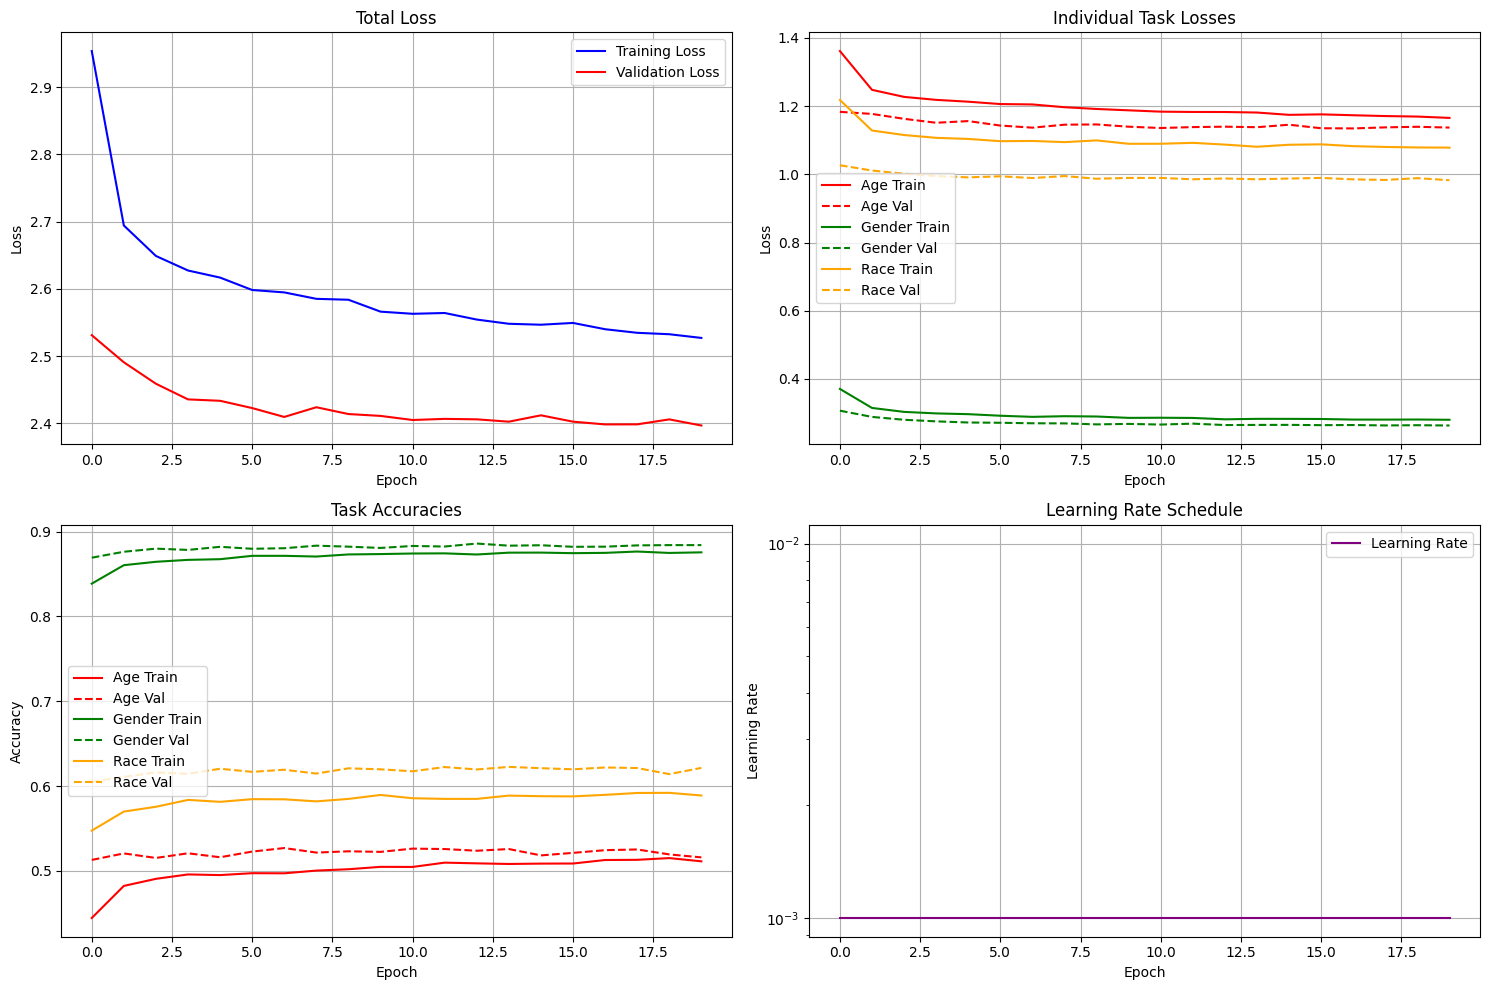

Final Training Metrics:
Total Loss: 2.5269 | Val Loss: 2.3966
Age Loss: 1.1655 | Val: 1.1371
Gender Loss: 0.2804 | Val: 0.2636
Race Loss: 1.0783 | Val: 0.9828
Age Accuracy: 0.5114 | Val: 0.5160
Gender Accuracy: 0.8756 | Val: 0.8842
Race Accuracy: 0.5890 | Val: 0.6215
Final Learning Rate: 1.00e-03


In [12]:
def plot_history(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Total Loss (Training vs Validation)
    ax1.plot(history.history['loss'], label='Training Loss', color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Total Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Individual Task Losses
    ax2.plot(history.history['age_output_loss'], label='Age Train', color='red', linestyle='-')
    ax2.plot(history.history['val_age_output_loss'], label='Age Val', color='red', linestyle='--')
    ax2.plot(history.history['gender_output_loss'], label='Gender Train', color='green', linestyle='-')
    ax2.plot(history.history['val_gender_output_loss'], label='Gender Val', color='green', linestyle='--')
    ax2.plot(history.history['race_output_loss'], label='Race Train', color='orange', linestyle='-')
    ax2.plot(history.history['val_race_output_loss'], label='Race Val', color='orange', linestyle='--')
    ax2.set_title('Individual Task Losses')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    # Task Accuracies 
    ax3.plot(history.history['age_output_sparse_categorical_accuracy'], label='Age Train', color='red', linestyle='-')
    ax3.plot(history.history['val_age_output_sparse_categorical_accuracy'], label='Age Val', color='red', linestyle='--')
    ax3.plot(history.history['gender_output_binary_accuracy'], label='Gender Train', color='green', linestyle='-')
    ax3.plot(history.history['val_gender_output_binary_accuracy'], label='Gender Val', color='green', linestyle='--')
    ax3.plot(history.history['race_output_sparse_categorical_accuracy'], label='Race Train', color='orange', linestyle='-')
    ax3.plot(history.history['val_race_output_sparse_categorical_accuracy'], label='Race Val', color='orange', linestyle='--')
    ax3.set_title('Task Accuracies')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    ax3.grid(True)

    # Learning Rate
    ax4.plot(history.history['learning_rate'], label='Learning Rate', color='purple')
    ax4.set_title('Learning Rate Schedule')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Learning Rate')
    ax4.legend()
    ax4.grid(True)
    ax4.set_yscale('log') 

    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print("Final Training Metrics:")
    print(f"Total Loss: {history.history['loss'][-1]:.4f} | Val Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Age Loss: {history.history['age_output_loss'][-1]:.4f} | Val: {history.history['val_age_output_loss'][-1]:.4f}")
    print(f"Gender Loss: {history.history['gender_output_loss'][-1]:.4f} | Val: {history.history['val_gender_output_loss'][-1]:.4f}")
    print(f"Race Loss: {history.history['race_output_loss'][-1]:.4f} | Val: {history.history['val_race_output_loss'][-1]:.4f}")
    print(f"Age Accuracy: {history.history['age_output_sparse_categorical_accuracy'][-1]:.4f} | Val: {history.history['val_age_output_sparse_categorical_accuracy'][-1]:.4f}")
    print(f"Gender Accuracy: {history.history['gender_output_binary_accuracy'][-1]:.4f} | Val: {history.history['val_gender_output_binary_accuracy'][-1]:.4f}")
    print(f"Race Accuracy: {history.history['race_output_sparse_categorical_accuracy'][-1]:.4f} | Val: {history.history['val_race_output_sparse_categorical_accuracy'][-1]:.4f}")
    print(f"Final Learning Rate: {history.history['learning_rate'][-1]:.2e}")

plot_history(history)

In [24]:
def predict_sample(model, img_path, train_processor, img_size=(160, 160)):
    """
    Predict demographics for a single image
    """
    # Load and preprocess image - matching training preprocessing
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0

    # Apply same normalization as training (ImageNet standardization)
    img = tf.image.per_image_standardization(img)
    img = tf.expand_dims(img, axis=0)  # Add batch dim

    # Predict
    preds = model.predict(img, verbose=0)

    # Extract predictions - model returns a dictionary
    age_pred = np.argmax(preds['age_output'][0])
    gender_pred = np.argmax(preds['gender_output'][0])
    race_pred = np.argmax(preds['race_output'][0])

    # Decode labels using the training processor encoders
    age_label = train_processor.age_encoder.inverse_transform([age_pred])[0]
    gender_label = train_processor.gender_encoder.inverse_transform([gender_pred])[0]
    race_label = train_processor.race_encoder.inverse_transform([race_pred])[0]

    # Display - load original image for display
    display_img = tf.io.read_file(img_path)
    display_img = tf.image.decode_image(display_img, channels=3)
    display_img = tf.image.resize(display_img, img_size)
    display_img = tf.cast(display_img, tf.float32) / 255.0

    plt.figure(figsize=(8, 6))
    plt.imshow(display_img)
    plt.title(f"Predictions:\nAge: {age_label}\nGender: {gender_label}\nRace: {race_label}")
    plt.axis('off')
    plt.show()

    return age_label, gender_label, race_label

In [25]:
def test_predictions(model, train_processor, num_samples=3):
    """Test predictions on random samples from filtered training data"""

    # Get some sample files from the filtered training data
    sample_indices = np.random.choice(len(train_processor.df), num_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        print(f"\n=== Sample {i+1} ===")
        row = train_processor.df.iloc[idx]
        img_path = os.path.join(train_processor.img_dir, row['file'])

        # True labels
        true_age = row['age']
        true_gender = row['gender']
        true_race = row['race']

        print(f"True labels - Age: {true_age}, Gender: {true_gender}, Race: {true_race}")

        # Predict
        pred_age, pred_gender, pred_race = predict_sample(model, img_path, train_processor)

        # Compare
        print(f"Predicted - Age: {pred_age}, Gender: {pred_gender}, Race: {pred_race}")
        print(f"Correct - Age: {true_age == pred_age}, Gender: {true_gender == pred_gender}, Race: {true_race == pred_race}")


=== Sample 1 ===
True labels - Age: 50-59, Gender: Male, Race: Latino_Hispanic


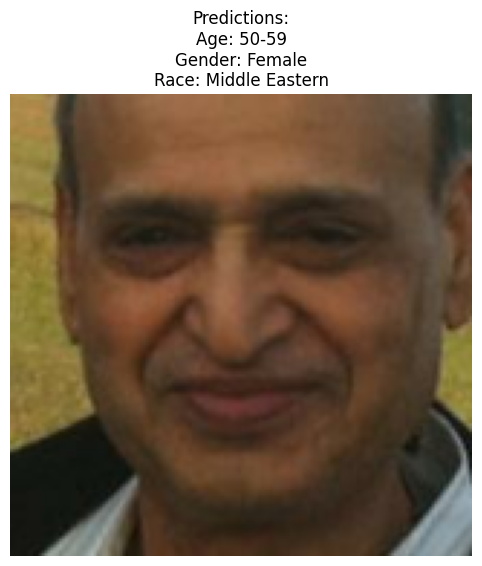

Predicted - Age: 50-59, Gender: Female, Race: Middle Eastern
Correct - Age: True, Gender: False, Race: False

=== Sample 2 ===
True labels - Age: 40-49, Gender: Male, Race: Middle Eastern


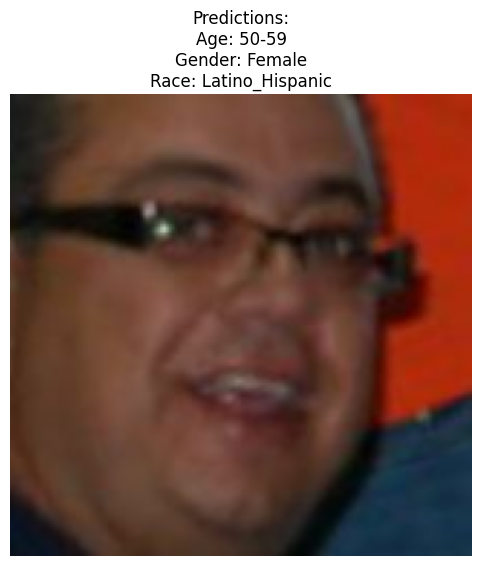

Predicted - Age: 50-59, Gender: Female, Race: Latino_Hispanic
Correct - Age: False, Gender: False, Race: False

=== Sample 3 ===
True labels - Age: 40-49, Gender: Male, Race: Latino_Hispanic


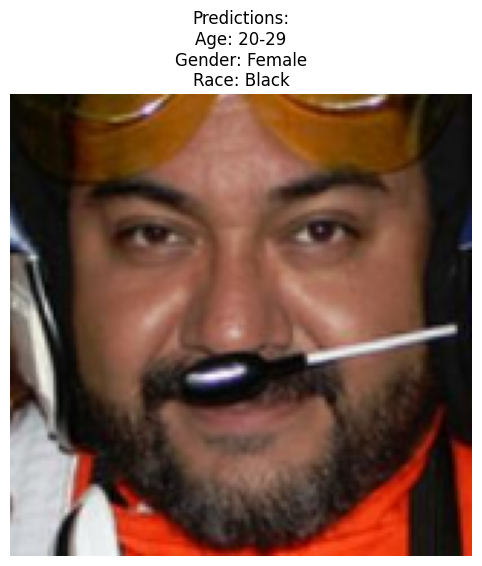

Predicted - Age: 20-29, Gender: Female, Race: Black
Correct - Age: False, Gender: False, Race: False

=== Sample 4 ===
True labels - Age: 20-29, Gender: Female, Race: East Asian


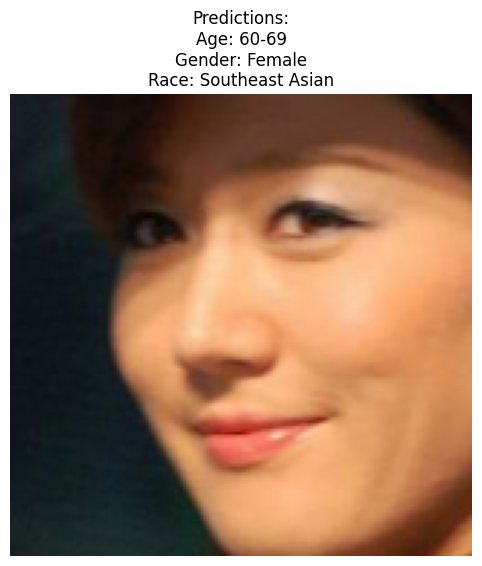

Predicted - Age: 60-69, Gender: Female, Race: Southeast Asian
Correct - Age: False, Gender: True, Race: False

=== Sample 5 ===
True labels - Age: 20-29, Gender: Male, Race: White


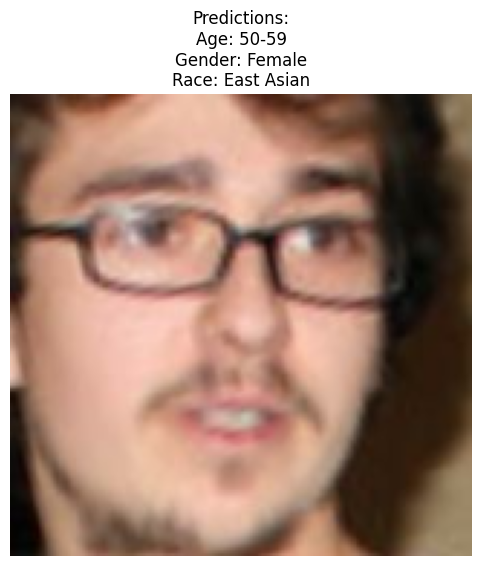

Predicted - Age: 50-59, Gender: Female, Race: East Asian
Correct - Age: False, Gender: False, Race: False


In [26]:
test_predictions(model, train_processor, num_samples=5)

In [27]:
print(model.summary())

Model: "face_net_multi_task"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v1             │ (None, 512)            │    23,497,424 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense (Dense)            │ (1, 512)               │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dropout (Dropout)        │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ age_head (Sequential)           │ (1, 9)                 │        66,825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gender_head (Sequential)        │ (1, 1)                 │           513 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ race_head (Sequential)          │ (1, 7)                 │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,831,009 (90.91 MB)

 Trainable params: 333,585 (1.27 MB)

 Non-trainable params: 23,497,424 (89.64 MB)

None


In [22]:
%pip install lime


Note: you may need to restart the kernel to use updated packages.


In [19]:
%pip install lime shap tf-explain alibi opencv-python scikit-image slicer lazy_loader numba cloudpickle spacy transformers attrs dill

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of spacy[lookups] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/545.3 kB ? eta -:

  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


In [1]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import warnings
from skimage.segmentation import quickshift
warnings.filterwarnings('ignore')

# LIME
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

# SHAP
import shap

# TF-Explain
import tf_explain
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.integrated_gradients import IntegratedGradients as TFIntegratedGradients
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

# Alibi
# from alibi.explainers import IntegratedGradients as AlibiIG

print("✅ All packages installed successfully")


✅ All packages installed successfully


In [2]:
class TensorFlowModelExplainer:
    def __init__(self, model, data_processor, task='age_output'):
        self.model = model
        self.data_processor = data_processor
        self.task = task
        
        if task == 'age_output':
            self.label_encoder = data_processor.age_encoder
        elif task == 'gender_output':
            self.label_encoder = data_processor.gender_encoder
        elif task == 'race_output':
            self.label_encoder = data_processor.race_encoder
        
        print(f"Explainer ready for {task}. Classes: {list(self.label_encoder.classes_)}")
    
    def preprocess_image(self, image_path):
        return self.data_processor.load_and_preprocess_image(image_path, augment=False)
    
    def predict_proba(self, images):
        if not isinstance(images, tf.Tensor):
            if images.ndim == 3:  
                images = images[np.newaxis, ...]
            images = tf.convert_to_tensor(images, dtype=tf.float32)
            if tf.reduce_max(images) > 1.0:
                images = images / 255.0
            images = tf.image.per_image_standardization(images)
        
        predictions = self.model(images, training=False)
        probs = tf.nn.softmax(predictions[self.task])
        return probs.numpy()
    
    def predict_class(self, images):
        return np.argmax(self.predict_proba(images), axis=1)
    
    def get_single_prediction(self, image_path):
        image = self.preprocess_image(image_path)
        image = tf.expand_dims(image, 0)
        predictions = self.model(image, training=False)
        probs = tf.nn.softmax(predictions[self.task])
        
        pred_class = tf.argmax(probs, axis=1)[0].numpy()
        confidence = probs[0, pred_class].numpy()
        label = self.label_encoder.inverse_transform([pred_class])[0]
        
        return {
            'predicted_class': pred_class,
            'predicted_label': label,
            'confidence': confidence,
            'all_probabilities': probs[0].numpy(),
            'class_names': list(self.label_encoder.classes_),
        }


In [3]:
class TensorFlowLIMEExplainer:
    def __init__(self, model_explainer):
        self.model_explainer = model_explainer
        self.explainer = lime_image.LimeImageExplainer()
        
    def explain_image(self, image_path, num_samples=1000):
        image_pil = Image.open(image_path).convert('RGB')
        image_np = np.array(image_pil.resize((160, 160)))
        
        pred_info = self.model_explainer.get_single_prediction(image_path)
        print(f"Explaining: {pred_info['predicted_label']} ({pred_info['confidence']:.3f})")
        
        def lime_predict_fn(images):
            processed = []
            for img in images:
                img = img.astype(np.float32) / 255.0
                img = tf.image.per_image_standardization(img)
                processed.append(img.numpy())
            return self.model_explainer.predict_proba(np.array(processed))
        
        explanation = self.explainer.explain_instance(
            image_np, lime_predict_fn,
            top_labels=len(pred_info['class_names']),
            num_samples=num_samples,
            segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)
        )
        return explanation, pred_info, image_np


In [4]:
class TensorFlowIntegratedGradients:
    def __init__(self, model_explainer):
        self.model_explainer = model_explainer
        self.model = model_explainer.model
        self.task = model_explainer.task
        self.ig_explainer = TFIntegratedGradients()
    
    def explain_image(self, image_path, steps=50):
        image = self.model_explainer.preprocess_image(image_path)
        image = tf.expand_dims(image, 0)
        pred_info = self.model_explainer.get_single_prediction(image_path)
        predicted_class = pred_info['predicted_class']
        image_np = image.numpy()

        # pred_tensor = self.model(image, training=False)
        # if isinstance(pred_tensor, dict):
        #     pred_tensor = pred_tensor[self.model_explainer.task]
        def model_wrapper(x):
            preds = self.model(x, training=False)
            if isinstance(preds, dict):
                preds = preds[self.model_explainer.task]
            return preds

        attributions = self.ig_explainer.explain(
            validation_data=(image_np, None),
            model=model_wrapper,
            # model=self.model,
            class_index=predicted_class,
            n_steps=steps
        )
        return attributions, pred_info, image


In [5]:
class TensorFlowGradCAM:
    def __init__(self, model_explainer, layer_name=None):
        self.model_explainer = model_explainer
        self.model = model_explainer.model
        self.task = model_explainer.task
        if layer_name is None:
            for layer in reversed(self.model.layers):
                if 'conv' in layer.name.lower() or 'inception' in layer.name.lower():
                    layer_name = layer.name
                    break
        self.layer_name = layer_name
        self.gradcam_explainer = GradCAM()

    
    
    def explain_image(self, image_path):
        image = self.model_explainer.preprocess_image(image_path)
        image = tf.expand_dims(image, 0)

        pred_info = self.model_explainer.get_single_prediction(image_path)
        predicted_class = pred_info['predicted_class']


        def _create_functional_wrapper(self):
            """
            Create a functional model that wraps your subclassed model
            """
            # Define input shape (based on your model)
            input_shape = (160, 160, 3)
            inputs = tf.keras.Input(shape=input_shape)
            
            # Get embeddings from backbone
            embeddings = self.model.backbone(inputs)
            
            # Shared processing
            shared_features = self.model.shared_dense(embeddings)
            shared_features = self.model.shared_dropout(shared_features)
            
            # Get task-specific output
            if self.task == 'age_output':
                outputs = self.model.age_classifier(shared_features)
            elif self.task == 'gender_output':
                outputs = self.model.gender_classifier(shared_features)
            elif self.task == 'race_output':
                outputs = self.model.race_classifier(shared_features)
            else:
                raise ValueError(f"Unknown task: {self.task}")
            
            # Create functional model
            functional_model = tf.keras.Model(inputs=inputs, outputs=outputs)
            return functional_model

        gradcam_heatmap = self.gradcam_explainer.explain(
            validation_data=(image.numpy(), None),
            model=_create_functional_wrapper,
            class_index=predicted_class,
            layer_name=self.layer_name
        )

        return gradcam_heatmap, pred_info, image

In [6]:
class TensorFlowOcclusion:
    def __init__(self, model_explainer):
        self.model_explainer = model_explainer
        self.model = model_explainer.model
        self.task = model_explainer.task
        self.occlusion_explainer = OcclusionSensitivity()
    
    def explain_image(self, image_path, patch_size=15):
        image = self.model_explainer.preprocess_image(image_path)
        image = tf.expand_dims(image, 0)
        pred_info = self.model_explainer.get_single_prediction(image_path)
        predicted_class = pred_info['predicted_class']

        def model_wrapper(x):
            """
            Wrapper to ensure model returns numerical probabilities
            """
            preds = self.model(x, training=False)
            
            # Handle dictionary output (multi-task models)
            if isinstance(preds, dict):
                preds = preds[self.task]
            
            # Ensure we have numerical probabilities
            # Apply softmax if raw logits, otherwise assume already probabilities
            if tf.reduce_max(preds) > 1.0 or tf.reduce_min(preds) < 0.0:
                preds = tf.nn.softmax(preds, axis=-1)
            
            return preds
        
        
        occlusion_map = self.occlusion_explainer.explain(
            validation_data=(image.numpy(), None),
            model=model_wrapper,
            # model=self.model,
            class_index=predicted_class,
            patch_size=patch_size
        )
        return occlusion_map, pred_info, image


In [7]:
class TensorFlowSHAP:
    def __init__(self, model_explainer, background_images):
        self.model_explainer = model_explainer
        self.model = model_explainer.model
        self.task = model_explainer.task
        self.explainer = shap.DeepExplainer(self.model, background_images)
    
    def explain_image(self, image_path):
        image = self.model_explainer.preprocess_image(image_path)
        image = tf.expand_dims(image, 0)
        pred_info = self.model_explainer.get_single_prediction(image_path)
        shap_values = self.explainer.shap_values(image.numpy())
        return shap_values, pred_info, image


In [8]:
def explain_tensorflow_prediction_comprehensive(model, data_processor, image_path, task='age'):
    print(f"🔍 Explaining {task} prediction for {image_path}")
    model_explainer = TensorFlowModelExplainer(model, data_processor, task)
    pred_info = model_explainer.get_single_prediction(image_path)
    print(f"Prediction: {pred_info['predicted_label']} ({pred_info['confidence']:.3f})")
    
    lime_explainer = TensorFlowLIMEExplainer(model_explainer)
    lime_exp, _, img_np = lime_explainer.explain_image(image_path)
    
    ig_explainer = TensorFlowIntegratedGradients(model_explainer)
    ig_attrs, _, _ = ig_explainer.explain_image(image_path)
    
    # gradcam_explainer = TensorFlowGradCAM(model_explainer)
    # gradcam_heatmap, _, _ = gradcam_explainer.explain_image(image_path)
    
    occ_explainer = TensorFlowOcclusion(model_explainer)
    # occ_map, _, _ = occ_explainer.explain_image(image_path)
    
    return {
        'lime_explanation': lime_exp,
        'ig_attributions': ig_attrs,
        # 'gradcam_heatmap': gradcam_heatmap,
        # 'occlusion_map': occ_map,
        'prediction_info': pred_info
    }


In [28]:
IMAGE_PATH = "C:/Users/DELL/Downloads/datasets/FairFace/val/1.jpg"


image = tf.expand_dims(val_processor.load_and_preprocess_image(IMAGE_PATH), 0)
predictions = model(image, training=False)
print(type(predictions))
print(predictions)


<class 'dict'>
{'age_output': <tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[0.10825837, 0.11439636, 0.11508814, 0.10988386, 0.11546166,
        0.09686423, 0.11583003, 0.11187664, 0.1123407 ]], dtype=float32)>, 'gender_output': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.502611]], dtype=float32)>, 'race_output': <tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[0.14841455, 0.14290097, 0.14641525, 0.13953833, 0.13467132,
        0.14641951, 0.14164014]], dtype=float32)>}


In [30]:
IMAGE_PATH = os.path.join(VAL_IMG_DIR, "1.jpg")
# IMAGE_PATH = "C:/Users/DELL/Downloads/datasets/FairFace/val/1.jpg"
explanations = explain_tensorflow_prediction_comprehensive(model, val_processor, IMAGE_PATH, task="race_output")


🔍 Explaining race_output prediction for C:/Users/aa24afl/Downloads/FairFace\val\1.jpg
Explainer ready for race_output. Classes: ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
Prediction: Southeast Asian (0.144)
Explaining: Southeast Asian (0.144)


100%|██████████| 1000/1000 [00:32<00:00, 31.10it/s]


In [48]:
class TensorFlowLIMEExplainer1:
    def __init__(self, model_explainer):
        self.model_explainer = model_explainer
        self.explainer = lime_image.LimeImageExplainer()

    def explain_and_visualize(self, image_path, num_samples=1000, top_classes=3, num_features=10):
    

        # Load and preprocess image
        image_pil = Image.open(image_path).convert('RGB')
        image_np = np.array(image_pil.resize((160, 160)))

        # Get prediction info
        pred_info = self.model_explainer.get_single_prediction(image_path)
        print("Prediction probabilities:")
        for i, label in enumerate(pred_info['class_names']):
            print(f"- {label}: {pred_info['all_probabilities'][i]:.3f}")

        print(f"\nExplaining top class: {pred_info['predicted_label']} ({pred_info['confidence']:.3f})")

        # LIME prediction function
        def lime_predict_fn(images):
            processed = []
            for img in images:
                img = img.astype(np.float32) / 255.0
                img = tf.image.per_image_standardization(img)
                processed.append(img.numpy())
            return self.model_explainer.predict_proba(np.array(processed))

        # Run LIME explanation
        explanation = self.explainer.explain_instance(
            image_np, lime_predict_fn,
            top_labels=top_classes,
            num_samples=num_samples,
            segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)
        )

        # Show contributions for each top class
        for cls_index in explanation.top_labels[:top_classes]:
            label_name = pred_info['class_names'][cls_index]
            print(f"\nTop superpixel contributions for class '{label_name}':")
            local_exp = explanation.local_exp[cls_index]
            for sp_id, weight in sorted(local_exp, key=lambda x: -abs(x[1]))[:num_features]:
                print(f"- Superpixel {sp_id}: {weight:.3f}")

        # Visualization: original, LIME overlay, contribution mask
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Original image
        axes[0].imshow(image_np)
        axes[0].set_title("Original Image")

        # LIME overlay for predicted class
        temp, mask = explanation.get_image_and_mask(
            pred_info['predicted_class'], positive_only=False, num_features=num_features, hide_rest=False)
        axes[1].imshow(temp)
        axes[1].set_title(f"LIME Explanation: {pred_info['predicted_label']}")

        # Contribution mask (positive vs negative)
        from matplotlib import cm
        cmap = cm.RdYlBu_r  # Red = negative, Blue = positive
        axes[2].imshow(mask, cmap=cmap)
        axes[2].set_title("Important Regions")

        for ax in axes:
            ax.axis("off")
        plt.show()

        return explanation, pred_info, image_np


In [103]:
class TensorFlowSHAP1:
    def __init__(self, model_explainer, background_images):
        self.model_explainer = model_explainer
        self.model = model_explainer.model
        self.task = model_explainer.task
        self.explainer = shap.DeepExplainer(self.model, background_images)
    
    def explain_and_visualize(self, image_path):
        image = self.model_explainer.preprocess_image(image_path)
        image = tf.expand_dims(image, 0)
        pred_info = self.model_explainer.get_single_prediction(image_path)
        shap_values = self.explainer.shap_values(image.numpy())
        
        shap_sum = np.sum(np.abs(shap_values[0][0]), axis=-1)
        plt.imshow(shap_sum, cmap="Reds")
        plt.title(f"SHAP - {pred_info['predicted_label']}")
        plt.axis("off")
        plt.show()
        
        return shap_values, pred_info, image


In [55]:
def explain_prediction_comprehensive(model, data_processor, background_images, image_path, task='age'):
    print(f"🔍 Explaining {task} prediction for {image_path}")
    model_explainer = TensorFlowModelExplainer(model, data_processor, task)
    pred_info = model_explainer.get_single_prediction(image_path)
    print(f"Prediction: {pred_info['predicted_label']} ({pred_info['confidence']:.3f})")
    
    TensorFlowLIMEExplainer1(model_explainer).explain_and_visualize(image_path)
    # TensorFlowIntegratedGradients(model_explainer).explain_and_visualize(image_path)
    # TensorFlowGradCAM(model_explainer).explain_and_visualize(image_path)
    # TensorFlowOcclusion(model_explainer).explain_and_visualize(image_path)

    # For SHAP, you need to pass background images manually.
    TensorFlowSHAP1(model_explainer, background_images).explain_and_visualize(image_path)
    
    return pred_info


C:/Users/aa24afl/Downloads/FairFace/val\1.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10.jpg
C:/Users/aa24afl/Downloads/FairFace/val\100.jpg
C:/Users/aa24afl/Downloads/FairFace/val\1000.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10000.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10001.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10002.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10003.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10004.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10005.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10006.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10007.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10008.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10009.jpg
C:/Users/aa24afl/Downloads/FairFace/val\1001.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10010.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10011.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10012.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10013.jpg
C:/Users/aa24afl/Downloads/FairFace/val\10014.jpg


🔍 Explaining race_output prediction for C:/Users/aa24afl/Downloads/FairFace\val\2.jpg
Explainer ready for race_output. Classes: ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
Prediction: Latino_Hispanic (0.144)
Prediction probabilities:
- Black: 0.14344240725040436
- East Asian: 0.14292064309120178
- Indian: 0.14295078814029694
- Latino_Hispanic: 0.14373520016670227
- Middle Eastern: 0.1405901312828064
- Southeast Asian: 0.14337079226970673
- White: 0.1429900825023651

Explaining top class: Latino_Hispanic (0.144)


100%|██████████| 1000/1000 [00:32<00:00, 30.84it/s]



Top superpixel contributions for class 'Latino_Hispanic':
- Superpixel 8: 0.001
- Superpixel 12: 0.000
- Superpixel 9: 0.000
- Superpixel 13: 0.000
- Superpixel 5: 0.000
- Superpixel 2: 0.000
- Superpixel 15: 0.000
- Superpixel 14: 0.000
- Superpixel 1: 0.000
- Superpixel 0: -0.000

Top superpixel contributions for class 'Black':
- Superpixel 8: -0.001
- Superpixel 14: -0.000
- Superpixel 12: -0.000
- Superpixel 7: 0.000
- Superpixel 18: -0.000
- Superpixel 5: 0.000
- Superpixel 13: -0.000
- Superpixel 4: 0.000
- Superpixel 2: -0.000
- Superpixel 1: -0.000

Top superpixel contributions for class 'Southeast Asian':
- Superpixel 8: 0.000
- Superpixel 4: -0.000
- Superpixel 14: -0.000
- Superpixel 15: -0.000
- Superpixel 7: -0.000
- Superpixel 13: 0.000
- Superpixel 5: -0.000
- Superpixel 3: -0.000
- Superpixel 9: -0.000
- Superpixel 6: 0.000


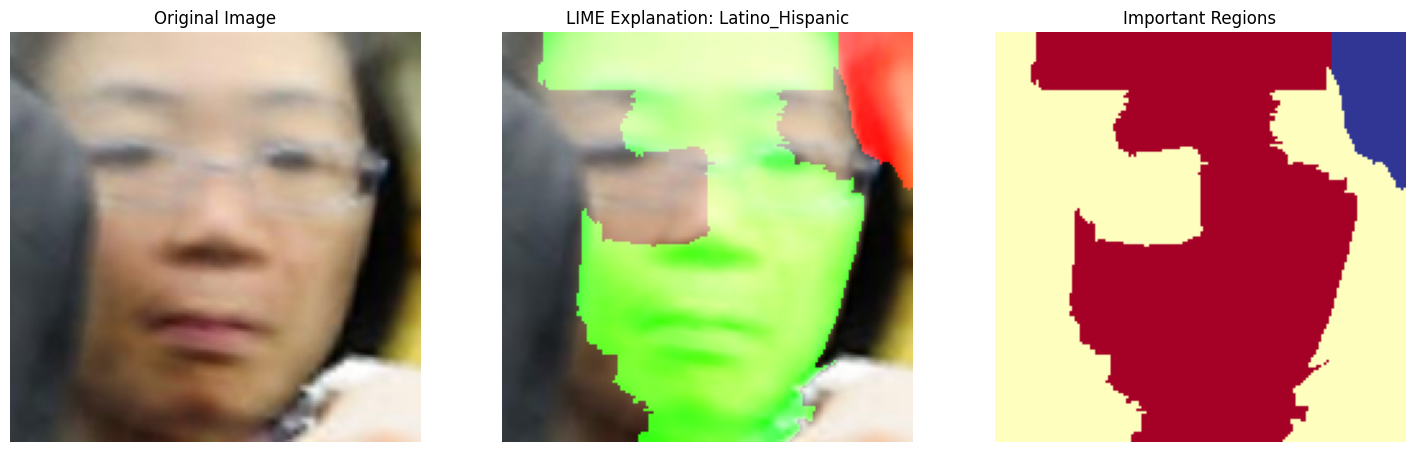

AttributeError: 'FaceNetMultiTask' object has no attribute 'model'

In [104]:
IMAGE_PATH = os.path.join(VAL_IMG_DIR, "2.jpg")
# IMAGE_PATH = "C:/Users/DELL/Downloads/datasets/FairFace/val/1.jpg"

val_images = os.listdir(VAL_IMG_DIR)[:20]
for img in val_images:
    bg_path = os.path.join(VAL_IMG_DIR, img)
    # print(bg_path)
    
background_images = []
# for path in bg_path:
img = Image.open(IMAGE_PATH).convert('RGB')
img = img.resize((160, 160))  # match your model input size
img = np.array(img).astype(np.float32) / 255.0
img = tf.image.per_image_standardization(img)
background_images.append(img.numpy())

background_images = np.array(background_images)

explanations = explain_prediction_comprehensive(model, val_processor, background_images, IMAGE_PATH, task="race_output")
